# Distribució freqüència

La distribució de freqüències de les similituds entre frases s'ha calculat per a cada categoria mitjançant la combinació encoder+mètrica que funciona millor: Word2Vec[mean] + cosine similarity. 

### Importo biblioteques i dependències

In [3]:
#!pip install unidecode
#!pip install gensim
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import unidecode
import re
from sklearn import metrics
import time
import collections
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
#nltk.download('punkt')
#nltk.download('stopwords')

### Càrrega del conjunt de dades

In [4]:
stemmer = SnowballStemmer('spanish')

In [5]:
#LListo tots els tfg dins de la categoria mecanica de fluids
llista_text_documents_mecanica_fluids = []
for file in glob.glob('TFG/00Data/dataset_txt/Electronica/*'):
    with open(file,'r') as txt:
        llista_text_documents_mecanica_fluids.append(txt.read())

In [6]:
len(llista_text_documents_mecanica_fluids)

22

### Distribució de freqüència vs similitud entre tots els documents d'una mateixa categoria mitjançant Word2Vec[mean] + Cosine Similarity

In [7]:
#Funció que permet pre-processar el text dins de qualsevol tfg i separar-lo en sentences
def clean_raw_text (documento):
    text_sentences = []
    text = str(documento).replace('\n',' ')
    text = nltk.sent_tokenize(text)
    
    for sentence in text:
        words = []
        word_tokens = nltk.word_tokenize(sentence)
        filtered_text = " ".join([w for w in word_tokens if not w in stopwords.words('spanish')])
        stemmed_text = " ".join(stemmer.stem(word) for word in nltk.word_tokenize(filtered_text))  
        no_punctuaction_text = re.sub(r'[^\w\s]','',stemmed_text)
        no_accents = unidecode.unidecode(no_punctuaction_text)
        no_digits_text = re.sub('\d', '', no_accents)
        for word in nltk.word_tokenize(no_digits_text):
            if len(word) >=2:
                words.append(word)
                                
        no_digits_text = " ".join(words)
        clean1 = re.sub(' +', ' ',no_digits_text)
        full_clean = clean1.strip()    
        text_sentences.append(full_clean)
        
    text_sentences = [x for x in text_sentences if x !='']
    return(text_sentences)

In [8]:
#Es crea una llista de llistes on per a cada document es llisten les diferents sentences pre-processades
document_sentences = []
for i in range (0,len(llista_text_documents_mecanica_fluids)):
    document_sentences.append(clean_raw_text(llista_text_documents_mecanica_fluids[i]))

In [9]:
%%time
#Creo el vocabulari pel Word2Vec amb totes les paraules dels documents base


vocab_words = []

for tfg in llista_text_documents_mecanica_fluids:
    tfg = tfg.replace('\n',' ')
    for parag in tfg.split(' '):
        words = []
        word_tokens = nltk.word_tokenize(parag)
        filtered_text = " ".join([w for w in word_tokens if not w in stopwords.words('spanish')])
        stemmed_text = " ".join(stemmer.stem(word) for word in nltk.word_tokenize(filtered_text))
        no_punctuaction_text = re.sub(r'[^\w\s]','',stemmed_text)
        no_accents = unidecode.unidecode(no_punctuaction_text)
        no_digits_text = re.sub('\d', '', no_accents)
        for word in nltk.word_tokenize(no_digits_text):
            if len(word) >=2:
                words.append(word)
                                
        no_digits_text = " ".join(words)
        clean1 = re.sub(' +', ' ',no_digits_text)
        full_clean = clean1.strip()       
        vocab_words.append(nltk.word_tokenize(full_clean))
    vocab_words
vocab_words = [x for x in vocab_words if x !=[]]
print(len(vocab_words))


214264
CPU times: user 3min 4s, sys: 16.9 s, total: 3min 21s
Wall time: 3min 26s


In [10]:
# Inicialitzo el Word2Vec amb totes les paraules dels documents base. 
#IMPORTANT: Especifico min_count = 1 per tal de no haver de filtrar les paraules.
w2v_model = Word2Vec(vocab_words,
                     size=50,
                     min_count=1,
                     #min_count=3,
                     window=4,
                     workers=4) 

w2v_model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

In [11]:
len(w2v_model.wv.vocab) #Vocabulari del word2vec

15301

In [12]:
#Creo una llista de llistes on tinc les diferents frases tokenitzades de cada document.
documents_frases_tokenitzades = []
for i in range (0,len(document_sentences)):
    frases_tokenitzades = []
    for sentence in document_sentences[i]:
        frases_tokenitzades.append(nltk.word_tokenize(sentence))#Tokenitzo cada frase, obtenint una llista de paraules per a cada frase
    documents_frases_tokenitzades.append(frases_tokenitzades)
    

In [13]:
#Transformo a vectors les paraules de cada frase de cada document a partir del wor2vec.
#No ha estat necessari filtrar les paraules perquè totes ja formen part del vocabulari. 
document_sentence_vectors = []
for i in range (0,len(documents_frases_tokenitzades)):
    frase_vectorizada = []
    for sentence in documents_frases_tokenitzades[i]:
        mean = []
        for word in sentence:
            mean.append(w2v_model.wv.get_vector(word))
        mean = np.array(mean).mean(axis=0)
        frase_vectorizada.append(mean)
    document_sentence_vectors.append(frase_vectorizada)

In [14]:
#Transformo els vectors d'una dimensió a dues dimensions per tal de poder aplicar posteriorment cosine similarity
document_sentence_vectors_good_format = []
for document in document_sentence_vectors:
    vectorizado_bueno = []
    for vector in document:
        vectorizado_bueno.append([vector])
    document_sentence_vectors_good_format.append(vectorizado_bueno)

In [15]:
def frases_similitud_coseno(document1,document2):
    similarities_between_sentences = []
    for vector1 in document1:
        for vector2 in document2:
            similarities_between_sentences.append(cosine_similarity(vector1,vector2))
    return(similarities_between_sentences)

In [16]:
%%time
## Càlcul similituds entre frases mitjançant cosine similarity
similarities_between_sentences = []
for j in range(0,len(document_sentence_vectors_good_format)):
    similitud_entre_dos_documents = []
    for i in range(0,len(document_sentence_vectors_good_format)):
        if j != i:
            similitud_entre_dos_documents.append(frases_similitud_coseno(document_sentence_vectors_good_format[j],document_sentence_vectors_good_format[i]))
    similarities_between_sentences.append(similitud_entre_dos_documents) 

CPU times: user 11h 24min 26s, sys: 4min, total: 11h 28min 27s
Wall time: 11h 33min 21s


In [17]:
#Número de similituds totals computades
llista_numero_similituds = []
for document in similarities_between_sentences:
    for another_document in document:
        llista_numero_similituds.append(len(another_document))
print('Número de similituds computades: '+str(sum(llista_numero_similituds)))

Número de similituds computades: 236775090


In [18]:
#Afegeixo totes les similituds computades a una única llista
llista_similituds = []
for document in similarities_between_sentences:
    for another_document in document:
        for similarity in another_document:
            llista_similituds.append(similarity)

In [19]:
#Calculo les unique similituds i els cops que apareix cadascuna
(unique,counts) = np.unique(llista_similituds, return_counts = True)
freq = np.asarray((unique,counts)).T
freq.shape

(55651955, 2)

In [20]:
x = freq[:,0] #Returns the first column

In [21]:
#Mitjana de la distribució de freqüències
x.mean()

0.024763432972851607

In [22]:
#Desviació estàndar de les distribucions de freqüència
x.std()

0.15801163071899615

CPU times: user 710 ms, sys: 17.1 ms, total: 727 ms
Wall time: 730 ms


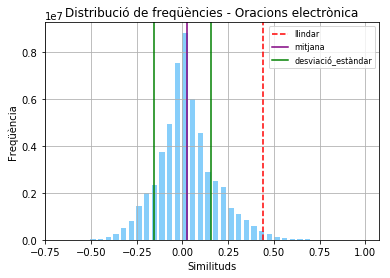

In [35]:
%%time
plt.hist(x=x,rwidth=0.7, bins=40,color='lightskyblue')
plt.grid()
plt.xlabel('Similituds')
plt.ylabel('Freqüència')
plt.title('Distribució de freqüències - Oracions electrònica')
plt.axvline(x=0.44,color='red',linestyle='dashed',label='llindar')
plt.axvline(x=0.024763, color = 'purple',label='mitjana')
plt.axvline(x=0.15801163,color='green',label='desviació_estàndar')
plt.axvline(x=-0.15801163,color='green')
plt.legend(prop={'size': 8})

In [32]:
similituds_majors_035 = []
for similarity in x:
    if similarity > 0.44:
        similituds_majors_035.append(similarity)
len(similituds_majors_035)

699937

In [33]:
100-(len(similituds_majors_035)/len(x))*100

98.74229575582744